In [4]:
# Load dataset and model if not continuing from before
import torch
import torchvision

from datasets import load_from_disk
from tqdm import tqdm
import datetime
from pathlib import Path
import time
from lerobot.common.datasets.utils import hf_transform_to_torch
import numpy as np
import mediapy as media


dataset_path = "../datasets/byol/grasp_100_2024-09-06_17-03-47.hf"
dataset_name = Path(dataset_path).stem
dataset = load_from_disk(dataset_path)
dataset.set_transform(hf_transform_to_torch)
# dataset.set_format("torch")

checkpoint = torch.load("../VINN/ckpts/resnet_byol_grasp_100_2024-09-06_17-03-47_2024-10-12_21-08/epoch_10.pt")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps")

# Remove the fc/classification layer
resnet = torchvision.models.resnet18()
modules = list(resnet.children())[:-1]
backbone = torch.nn.Sequential(*modules)
net = backbone
net.load_state_dict(checkpoint["policy_state_dict"])
net = net.to(device)



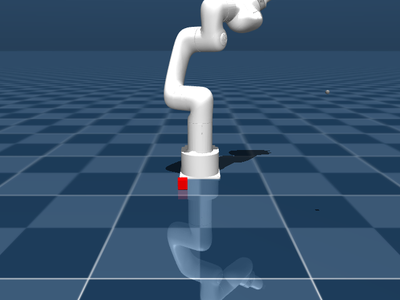

In [2]:
import gym_lite6.env, gym_lite6.pickup_task, gym_lite6.utils
import gymnasium as gym


task = gym_lite6.pickup_task.GraspAndLiftTask('gripper_left_finger', 'gripper_right_finger', 'box', 'floor')
env = gym.make(
    "UfactoryCubePickup-v0",
    task=task,
    obs_type="pixels_state",
    max_episode_steps=300,
)
observation, info = env.reset()
media.show_image(env.render(), width=400)


In [5]:
idx = np.random.randint(len(dataset))

img = dataset[idx]["observation.pixels.side"].unsqueeze(0).to(device)

# net(img)

In [19]:

net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [7]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
train_nodes, _ = get_graph_node_names(net)
print(train_nodes) 


['input', '0', '1', '2', '3', '4.0.conv1', '4.0.bn1', '4.0.relu', '4.0.conv2', '4.0.bn2', '4.0.add', '4.0.relu_1', '4.1.conv1', '4.1.bn1', '4.1.relu', '4.1.conv2', '4.1.bn2', '4.1.add', '4.1.relu_1', '5.0.conv1', '5.0.bn1', '5.0.relu', '5.0.conv2', '5.0.bn2', '5.0.downsample.0', '5.0.downsample.1', '5.0.add', '5.0.relu_1', '5.1.conv1', '5.1.bn1', '5.1.relu', '5.1.conv2', '5.1.bn2', '5.1.add', '5.1.relu_1', '6.0.conv1', '6.0.bn1', '6.0.relu', '6.0.conv2', '6.0.bn2', '6.0.downsample.0', '6.0.downsample.1', '6.0.add', '6.0.relu_1', '6.1.conv1', '6.1.bn1', '6.1.relu', '6.1.conv2', '6.1.bn2', '6.1.add', '6.1.relu_1', '7.0.conv1', '7.0.bn1', '7.0.relu', '7.0.conv2', '7.0.bn2', '7.0.downsample.0', '7.0.downsample.1', '7.0.add', '7.0.relu_1', '7.1.conv1', '7.1.bn1', '7.1.relu', '7.1.conv2', '7.1.bn2', '7.1.add', '7.1.relu_1', '8']


In [10]:
return_nodes = ["4", '5', '6']
model2 = create_feature_extractor(net, return_nodes=return_nodes)
intermediate_outputs = model2(img)
print(intermediate_outputs)

{'4': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0142],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1323, 0.1625],
          [0.0000, 0.0726, 0.0811,  ..., 0.0364, 0.3383, 0.3220],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1007, 0.3764, 0.2590],
          [0.0124, 0.0600, 0.1017,  ..., 0.3080, 0.5255, 0.2975],
          [0.0971, 0.1367, 0.1487,  ..., 0.2886, 0.3992, 0.2219]],

         [[0.8495, 0.4021, 0.4675,  ..., 0.2124, 0.4926, 0.4781],
          [0.9918, 0.6052, 0.7113,  ..., 0.4202, 0.8824, 0.5950],
          [1.2095, 0.8987, 1.1323,  ..., 0.8600, 1.2663, 0.8453],
          ...,
          [0.7784, 0.2024, 0.2633,  ..., 0.0000, 0.0000, 0.0000],
          [0.6976, 0.2040, 0.1831,  ..., 0.0000, 0.4413, 0.3410],
          [0.4415, 0.0000, 0.0000,  ..., 0.0342, 0.2923, 0.1922]],

         [[0.1054, 0.1120, 0.0645,  ..., 0.1111, 0.0784, 0.0000],
          [0.3793, 0.4118, 0.0922,  ..., 0.2075, 0.2644, 0.0604],
          [0.4208, 0.2070, 0.0000,  

In [11]:
for k in intermediate_outputs:
  print(intermediate_outputs[k].shape)

torch.Size([1, 64, 60, 80])
torch.Size([1, 128, 30, 40])
torch.Size([1, 256, 15, 20])



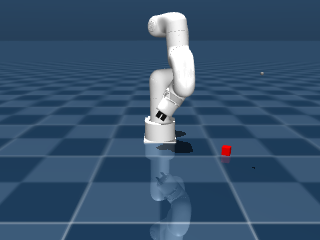

In [12]:
media.show_image(img.detach().cpu().squeeze().permute(1, 2, 0))

Plot 4
Plot 5
Plot 6


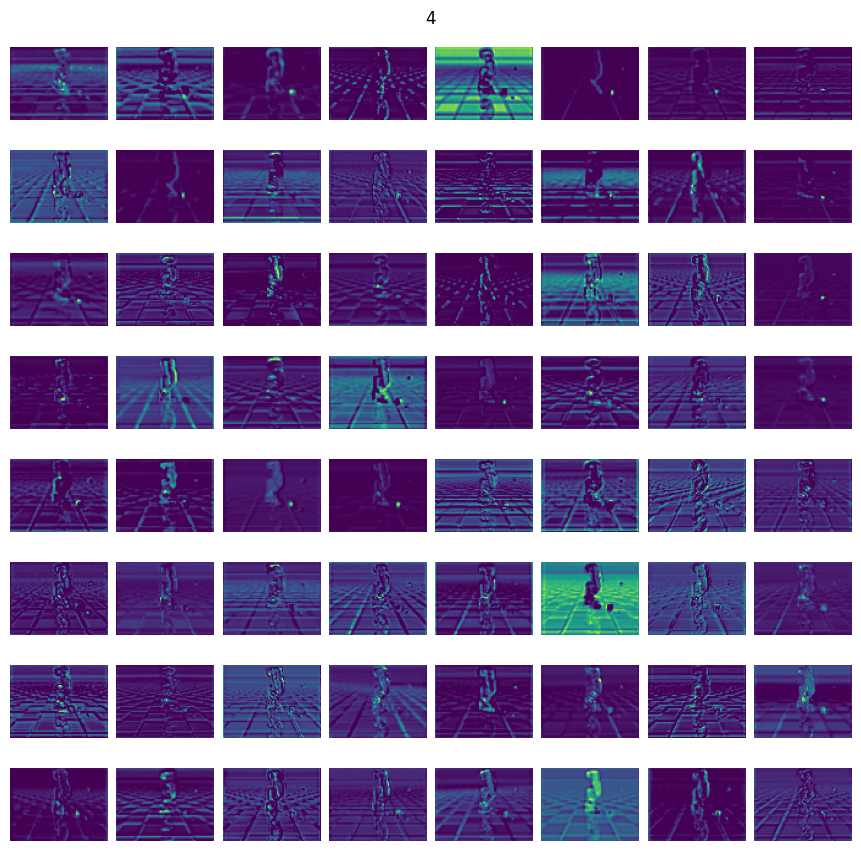

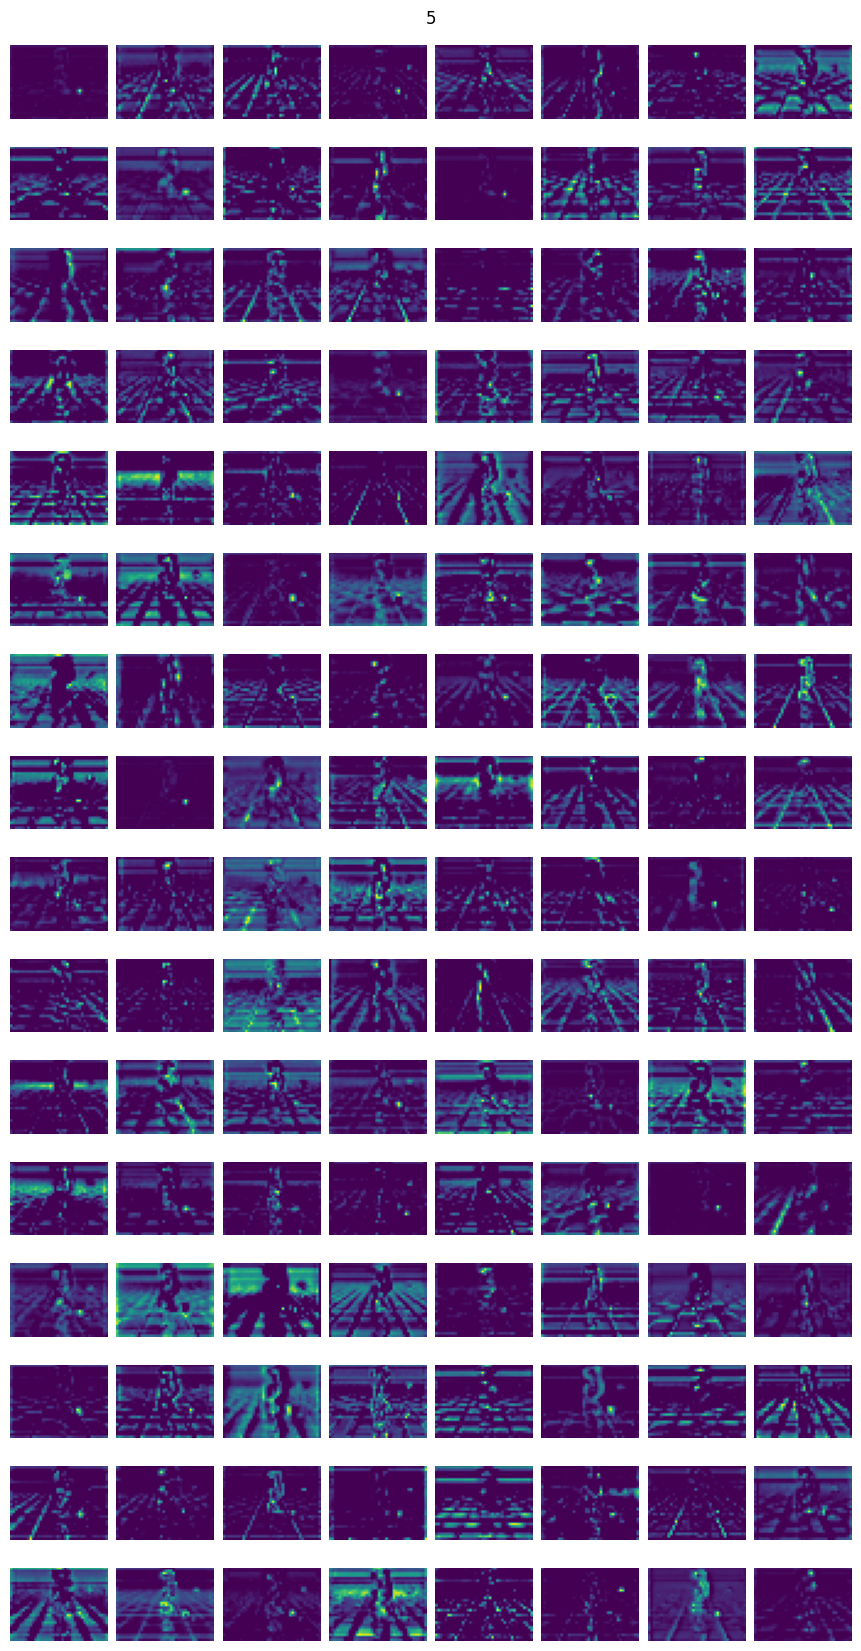

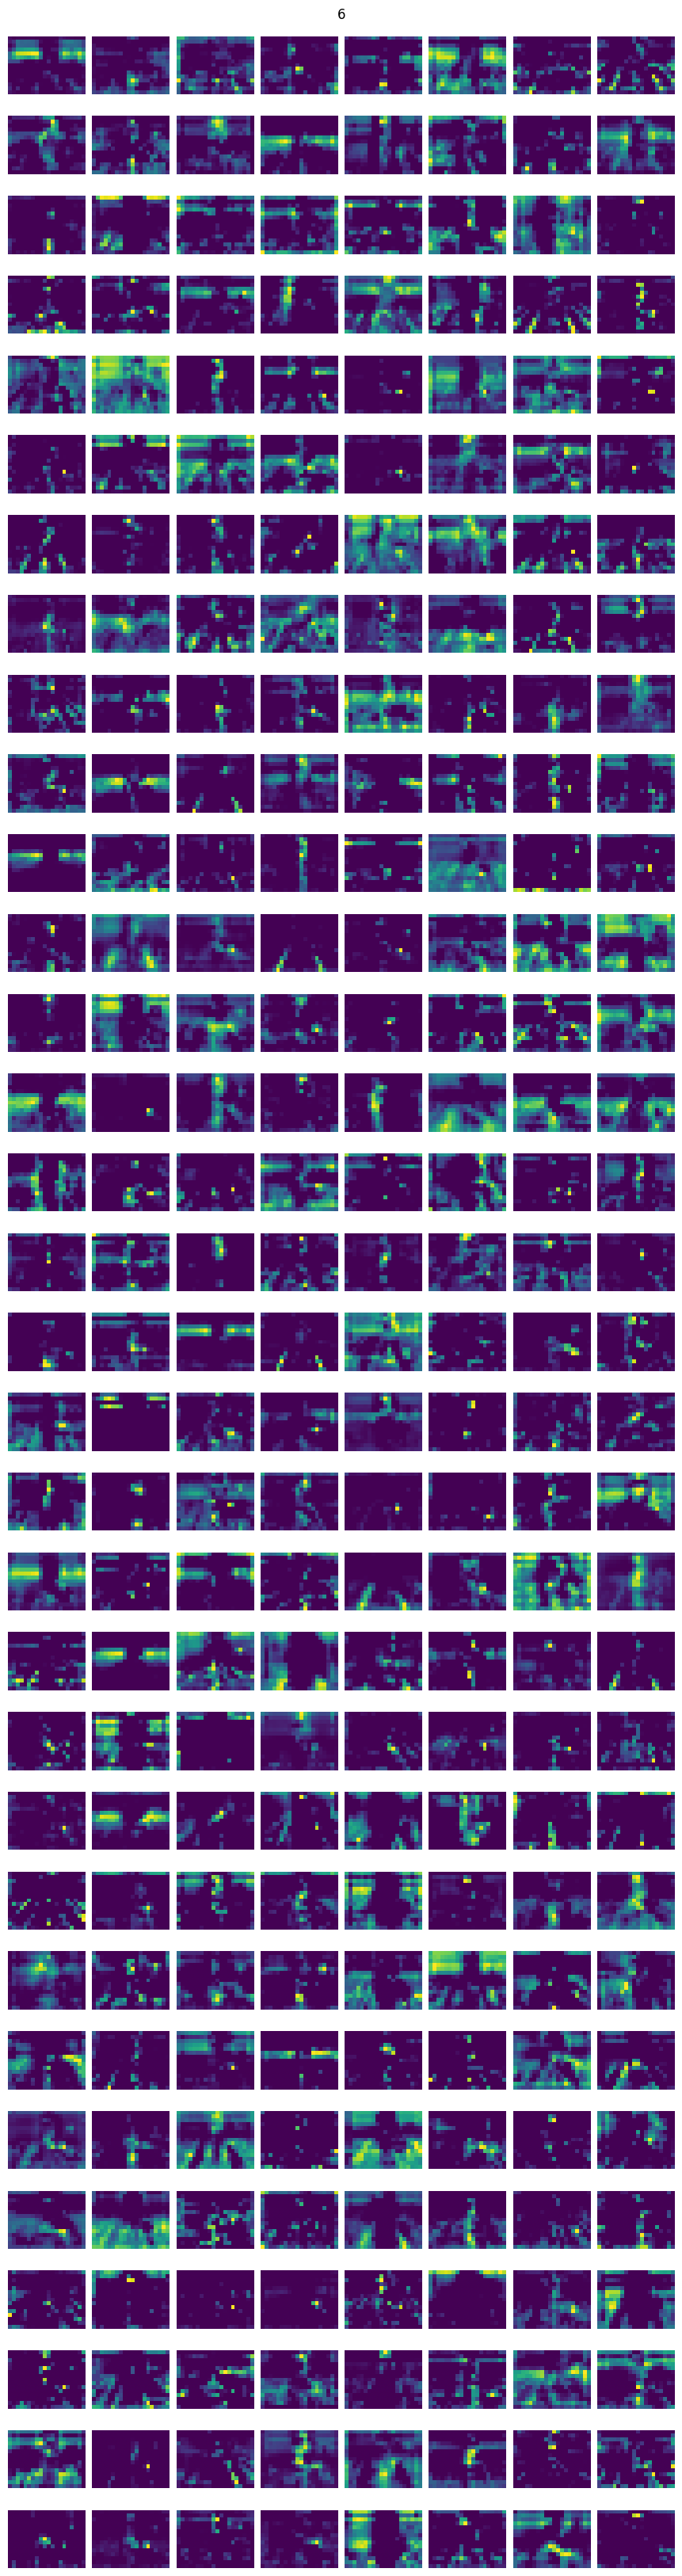

In [13]:
import matplotlib.pyplot as plt

for key in intermediate_outputs.keys():
  print(f"Plot {key}")
  plt_data = intermediate_outputs[key].detach().cpu().squeeze().numpy()
  ncols = min(plt_data.shape[0], 8)
  nrows= int(np.ceil(plt_data.shape[0]/ncols))
  fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(ncols*1+0.5, nrows*1+0.5), constrained_layout=True)
  for i in range(plt_data.shape[0]):
      ax = axs.flatten()[i]
      ax.imshow(plt_data[i])
      ax.set_axis_off()
      # ax.set_title(i)
  plt.suptitle(f"{key}")

torch.Size([1, 64, 60, 80])
torch.Size([1, 128, 30, 40])
torch.Size([1, 256, 15, 20])
Plot layer1
Plot layer2
Plot layer3


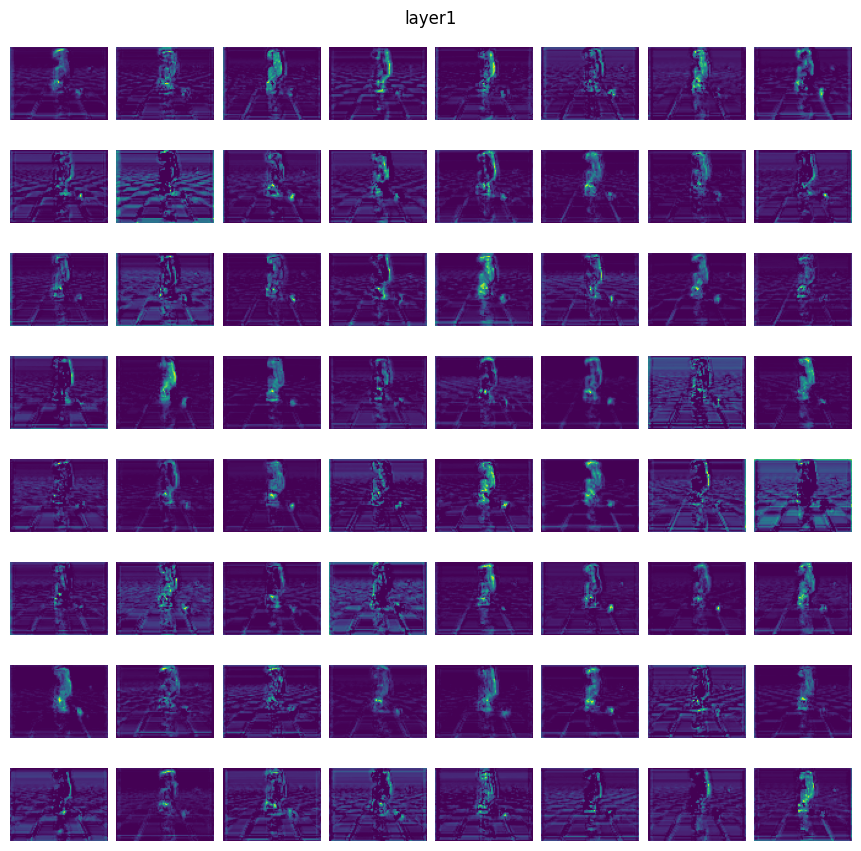

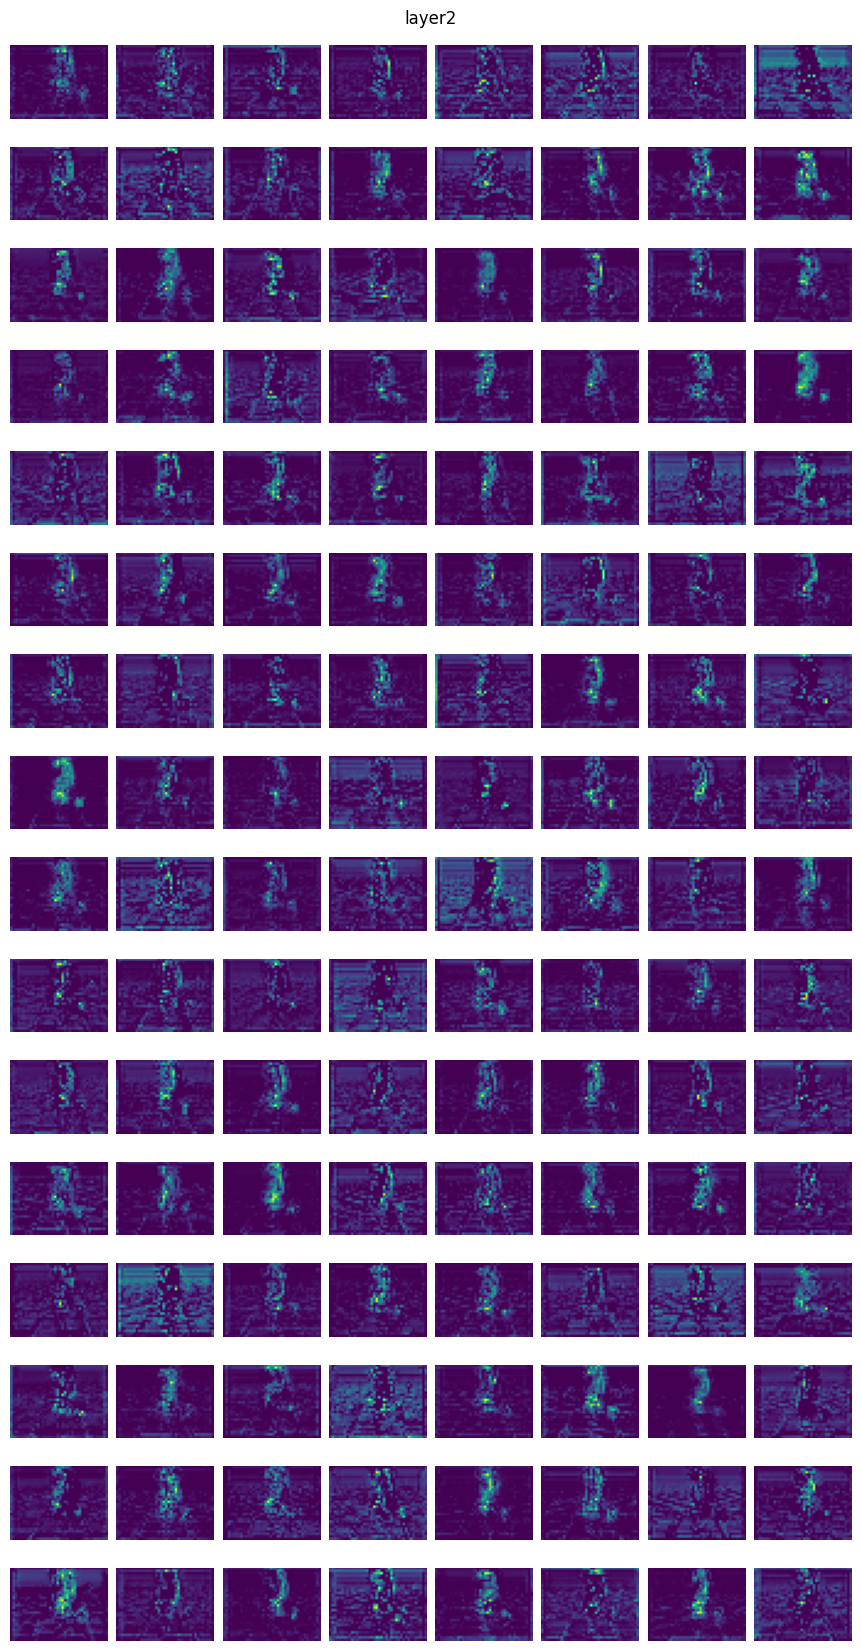

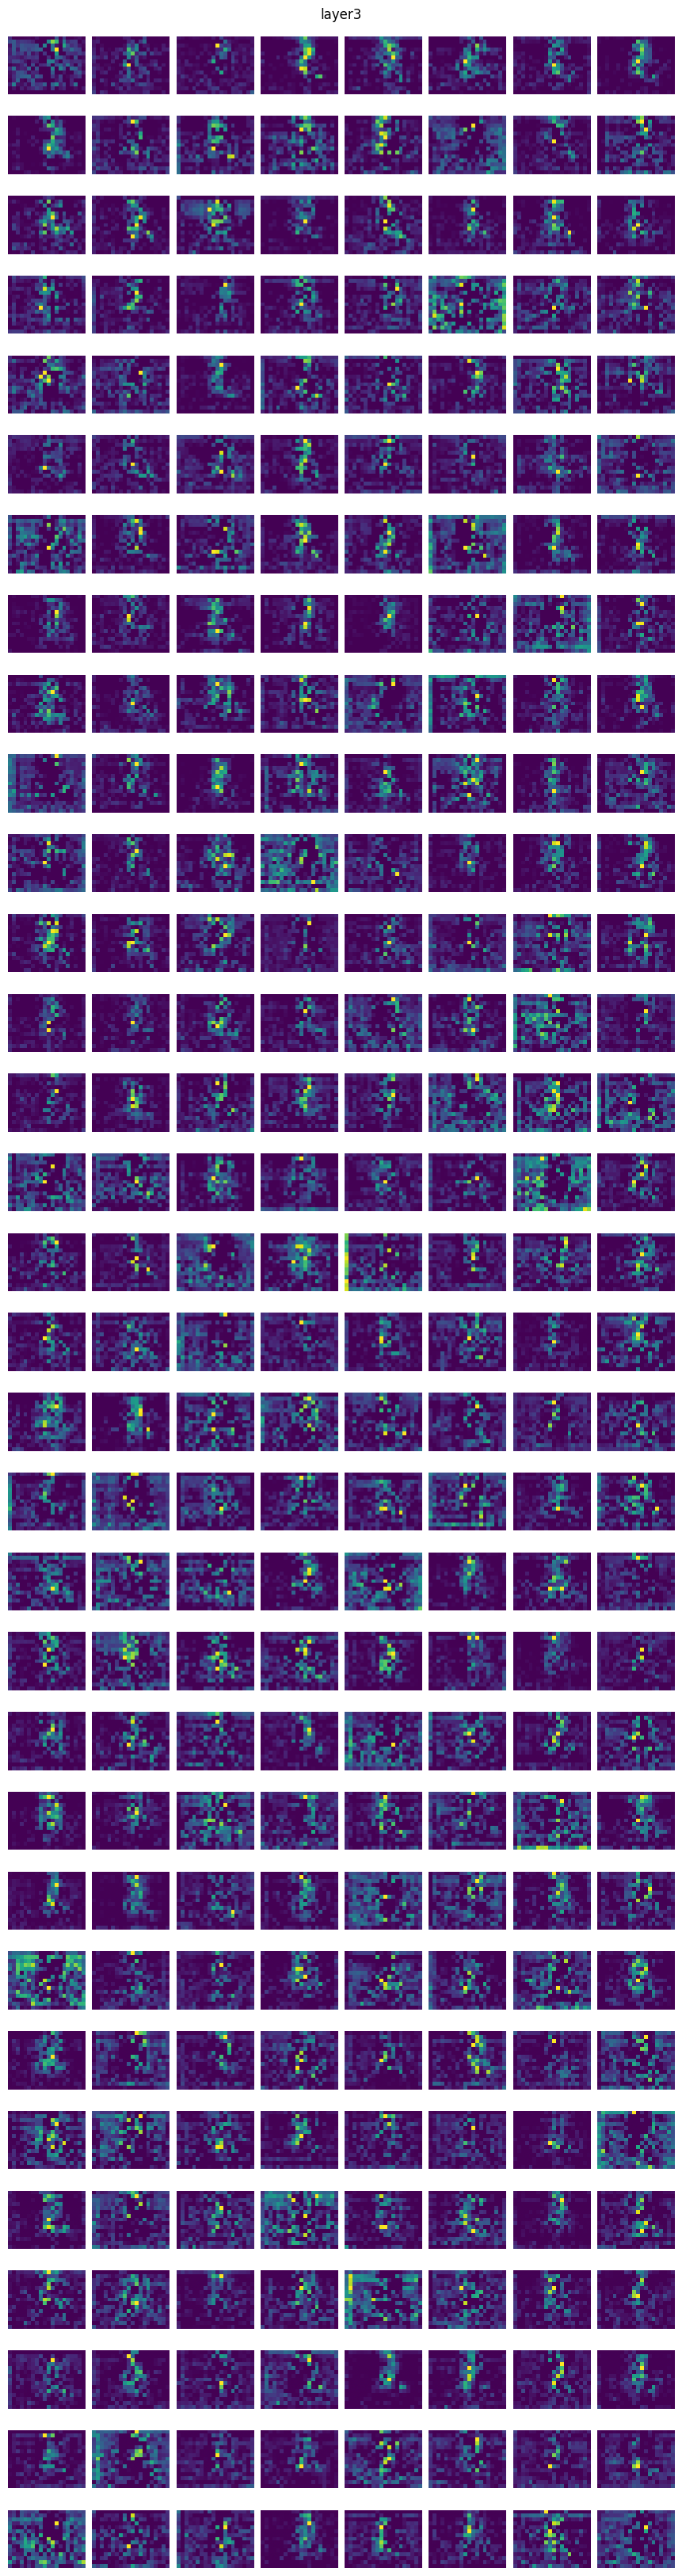

In [28]:
resnet_random = torchvision.models.resnet18().to("cuda")
return_nodes = ['layer1', 'layer2', 'layer3']
resnet_random2 = create_feature_extractor(resnet_random, return_nodes=return_nodes)
intermediate_outputs = resnet_random2(img)

for k in intermediate_outputs:
  print(intermediate_outputs[k].shape)

for key in intermediate_outputs.keys():
  print(f"Plot {key}")
  plt_data = intermediate_outputs[key].detach().cpu().squeeze().numpy()
  ncols = min(plt_data.shape[0], 8)
  nrows= int(np.ceil(plt_data.shape[0]/ncols))
  fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(ncols*1+0.5, nrows*1+0.5), constrained_layout=True)
  for i in range(plt_data.shape[0]):
      ax = axs.flatten()[i]
      ax.imshow(plt_data[i])
      ax.set_axis_off()
      # ax.set_title(i)
  plt.suptitle(f"{key}")

torch.Size([1, 64, 60, 80])
torch.Size([1, 128, 30, 40])
torch.Size([1, 256, 15, 20])
Plot layer1
Plot layer2
Plot layer3


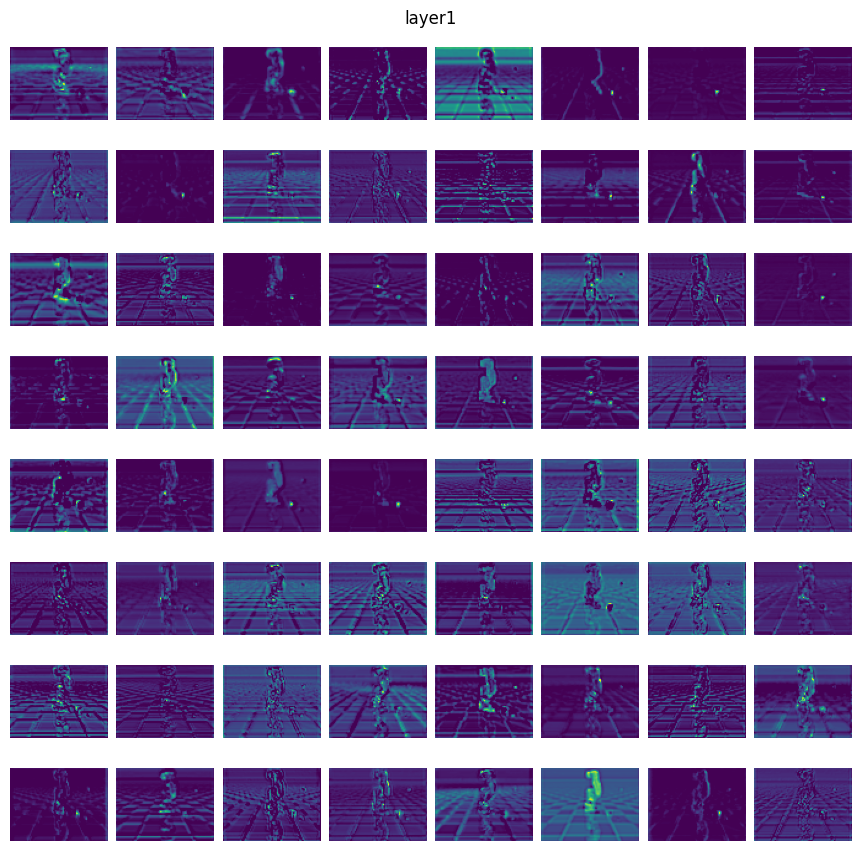

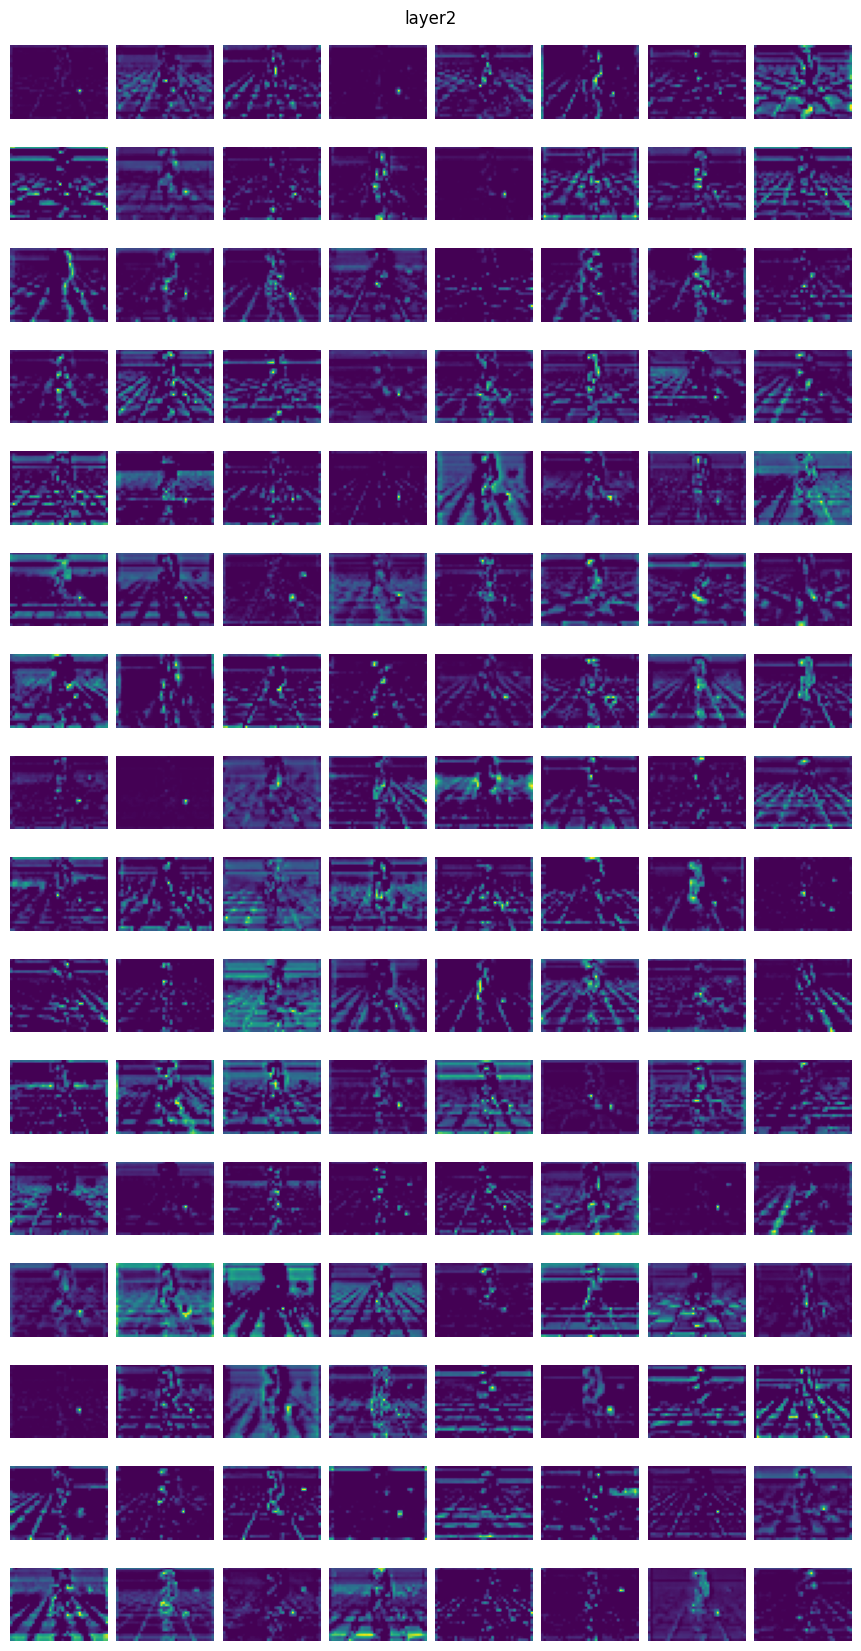

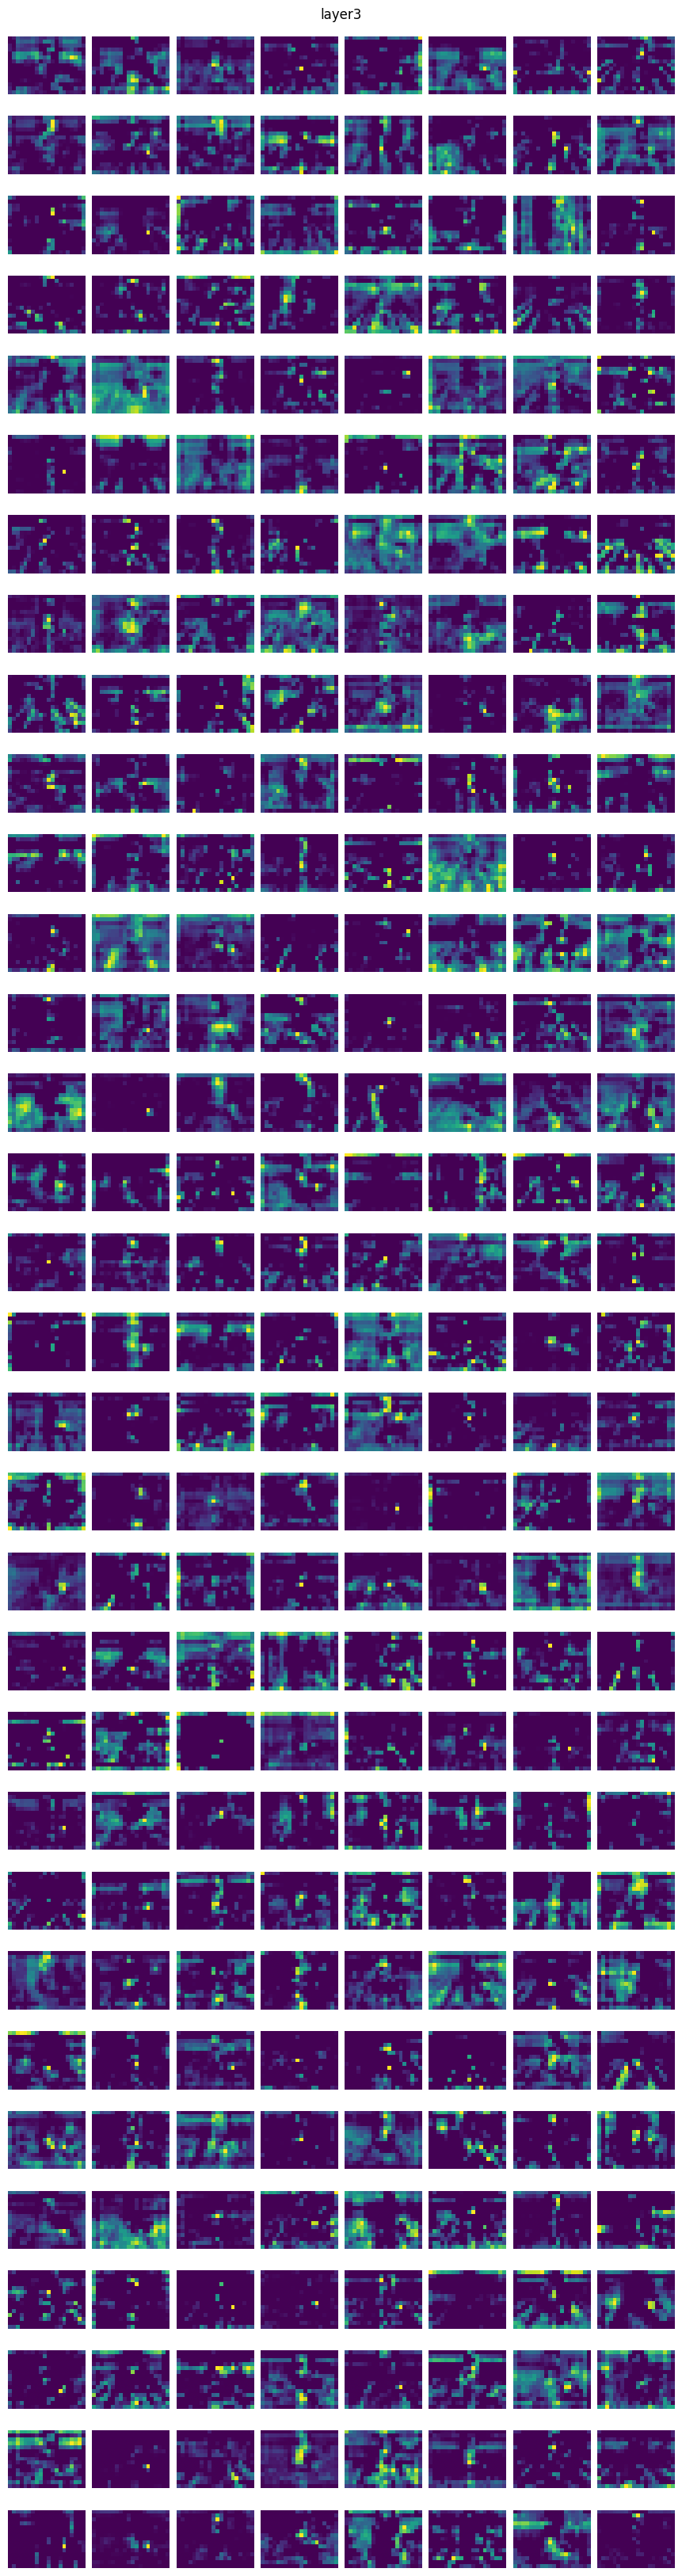

In [29]:
resnet_default = torchvision.models.resnet18(weights="DEFAULT").to("cuda")
return_nodes = ['layer1', 'layer2', 'layer3']
resnet_default2 = create_feature_extractor(resnet_default, return_nodes=return_nodes)
intermediate_outputs = resnet_default2(img)

for k in intermediate_outputs:
  print(intermediate_outputs[k].shape)

for key in intermediate_outputs.keys():
  print(f"Plot {key}")
  plt_data = intermediate_outputs[key].detach().cpu().squeeze().numpy()
  ncols = min(plt_data.shape[0], 8)
  nrows= int(np.ceil(plt_data.shape[0]/ncols))
  fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(ncols*1+0.5, nrows*1+0.5), constrained_layout=True)
  for i in range(plt_data.shape[0]):
      ax = axs.flatten()[i]
      ax.imshow(plt_data[i])
      ax.set_axis_off()
      # ax.set_title(i)
  plt.suptitle(f"{key}")